In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Path to your file
file_path = "/content/drive/MyDrive/Colab Notebooks/instagram_synthetic_full.csv"

# Read CSV
df = pd.read_csv(file_path)

# Show first 5 rows
print(df.head())

# Remove duplicates
df.drop_duplicates(inplace=True)

# Check missing values
print(df.isnull().sum())

df.describe()    # Mean, std, min, max, etc.


Mounted at /content/drive
   followers  verified                   post_time   likes  \
0    6423488     False  2025-05-27 13:47:36.168804  588218   
1    6550734     False  2023-09-06 19:45:12.168804  605837   
2    4304672     False  2024-04-18 17:52:00.168804  139658   
3    2234589     False  2024-01-01 13:28:18.168804   42177   
4    9958714     False  2025-07-05 05:35:46.168804  794445   

                        caption                    hashtags  
0     Sundays are for self-care              #nature #music  
1         Just a casual day out               #selfie #food  
2     Sundays are for self-care                 #art #music  
3  Feeling blessed and grateful                     #nature  
4     Sundays are for self-care  #food #art #fashion #music  
followers    0
verified     0
post_time    0
likes        0
caption      0
hashtags     0
dtype: int64


,followers,likes
count,9.000000e+04,90000.000000
mean,4.987597e+06,274644.378367
std,2.877170e+06,218120.291356
min,1.370000e+02,9.000000
25%,2.493876e+06,97969.000000
50%,4.977934e+06,217713.000000
75%,7.460077e+06,406966.250000
max,9.999987e+06,997375.000000


from matplotlib import pyplot as plt
_df_0['followers'].plot(kind='hist', bins=20, title='followers')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['likes'].plot(kind='hist', bins=20, title='likes')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('index').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='followers', y='likes', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4['followers'].plot(kind='line', figsize=(8, 4), title='followers')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_5['likes'].plot(kind='line', figsize=(8, 4), title='likes')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_6['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_6, x='followers', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_7['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_7, x='likes', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [2]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)


In [3]:
print(df['likes'].describe())


count     90000.000000
mean     274644.378367
std      218120.291356
min           9.000000
25%       97969.000000
50%      217713.000000
75%      406966.250000
max      997375.000000
Name: likes, dtype: float64


In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Example: Load your dataset (replace this with your actual data loading)
# DataFrame columns: follower_count, verified, post_time, caption, hashtags, likes

# For demo, create dummy data
np.random.seed(42)
data_size = 1000
df = pd.DataFrame({
    'follower_count': np.random.randint(100, 1000000, size=data_size),
    'verified': np.random.randint(0, 2, size=data_size),
    'post_time': np.random.randint(0, 24, size=data_size),  # hour of day
    'caption': np.random.choice([
        "Love this!", "Amazing view #sunset", "Check this out #fun #travel",
        "Happy day #life", "Throwback #memories"], size=data_size),
    'hashtags': np.random.choice([
        "#fun #travel", "#life", "#sunset #beach", "#memories", ""], size=data_size),
    'likes': np.random.randint(10, 100000, size=data_size)
})

# Step 1: Combine caption and hashtags into one text input
df['text'] = df['caption'] + " " + df['hashtags']

# Step 2: Process the target "likes" to reduce digits
# Option 1: simple division to reduce scale
df['likes_scaled'] = df['likes'] / 1000.0

# Option 2: log transform (plus 1 to avoid log(0))
df['likes_log'] = np.log1p(df['likes'])

# Choose one for training, e.g. likes_log
target = df['likes_log'].values

# Step 3: Prepare tabular inputs
tabular_features = ['follower_count', 'verified', 'post_time']
X_tabular = df[tabular_features].values

# Standardize numerical features (follower_count and post_time)
scaler = StandardScaler()
X_tabular[:, [0, 2]] = scaler.fit_transform(X_tabular[:, [0, 2]])

# Step 4: Prepare text inputs
texts = df['text'].values

# Tokenize text data
max_vocab_size = 5000
max_seq_len = 30

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X_text = pad_sequences(sequences, maxlen=max_seq_len, padding='post', truncating='post')

# Step 5: Split dataset
X_tab_train, X_tab_val, X_text_train, X_text_val, y_train, y_val = train_test_split(
    X_tabular, X_text, target, test_size=0.2, random_state=42
)

# === Model 1: Tabular-only ===
def build_tabular_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

tabular_model = build_tabular_model((X_tab_train.shape[1],))
tabular_model.summary()

# Train tabular model
tabular_history = tabular_model.fit(X_tab_train, y_train,
                  validation_data=(X_tab_val, y_val),
                  epochs=10, batch_size=32)

# === Model 2: Text-only ===
def build_text_model(vocab_size, seq_len, embed_dim=50):
    inputs = Input(shape=(seq_len,))
    x = Embedding(vocab_size, embed_dim, mask_zero=True)(inputs)
    x = LSTM(64, return_sequences=False)(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

text_model = build_text_model(max_vocab_size, max_seq_len)
text_model.summary()

# Train text model
text_history = text_model.fit(X_text_train, y_train,
               validation_data=(X_text_val, y_val),
               epochs=10, batch_size=32)

# === Model 3: Multimodal (Tabular + Text) ===
def build_multimodal_model(vocab_size, seq_len, tabular_shape, embed_dim=50):
    # Text branch
    text_input = Input(shape=(seq_len,), name='text_input')
    x1 = Embedding(vocab_size, embed_dim, mask_zero=True)(text_input)
    x1 = LSTM(64)(x1)
    x1 = Dense(32, activation='relu')(x1)

    # Tabular branch
    tab_input = Input(shape=tabular_shape, name='tabular_input')
    x2 = Dense(64, activation='relu')(tab_input)
    x2 = Dropout(0.3)(x2)
    x2 = Dense(32, activation='relu')(x2)

    # Combine
    combined = Concatenate()([x1, x2])
    combined = Dense(32, activation='relu')(combined)
    outputs = Dense(1, activation='linear')(combined)

    model = Model(inputs=[text_input, tab_input], outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

multimodal_model = build_multimodal_model(max_vocab_size, max_seq_len, (X_tab_train.shape[1], ))
multimodal_model.summary()

# Train multimodal model
multimodal_history = multimodal_model.fit({'text_input': X_text_train, 'tabular_input': X_tab_train},
                    y_train,
                    validation_data=({'text_input': X_text_val, 'tabular_input': X_tab_val}, y_val),
                    epochs=10, batch_size=32)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,369 (9.25 KB)

 Trainable params: 2,369 (9.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 107.3066 - mae: 10.3146 - val_loss: 96.3556 - val_mae: 9.7722
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 91.0079 - mae: 9.4767 - val_loss: 71.7674 - val_mae: 8.4034
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 62.8556 - mae: 7.8114 - val_loss: 36.9014 - val_mae: 5.8937
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 27.9948 - mae: 4.9814 - val_loss: 10.2131 - val_mae: 2.6457
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8102 - mae: 2.4811 - val_loss: 5.2832 - val_mae: 1.9045
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.1073 - mae: 1.9707 - val_loss: 4.1577 - val_mae: 1.6784
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8736 - mae: 1.8045 - val_loss: 3.3882 - val_mae: 1.5008
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0654 - mae: 1.8263 - val_loss: 2.7449 - val_mae: 1.3455
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 30, 50)    │    250,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 30)        │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     29,440 │ embedding_2[0][0… │
│                     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 32)        │      2,080 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │         33 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 281,553 (1.07 MB)

 Trainable params: 281,553 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 108.4319 - mae: 10.3614 - val_loss: 79.6036 - val_mae: 8.8484
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 50.2642 - mae: 6.5284 - val_loss: 7.1377 - val_mae: 2.3324
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 5.8456 - mae: 1.9909 - val_loss: 2.6108 - val_mae: 1.0895
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 2.1124 - mae: 1.0231 - val_loss: 1.9164 - val_mae: 0.9435
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.7414 - mae: 0.9333 - val_loss: 1.5184 - val_mae: 0.8479
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.4153 - mae: 0.8563 - val_loss: 1.2994 - val_mae: 0.8117
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.2550 - mae: 0.8217 - val_loss: 1.1949 - val_mae: 0.8075
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.2032 - mae: 0.8379 - val_loss: 1.1194 - val_mae: 0.7917
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 30, 50)    │    250,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 30)        │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │        256 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 64)        │     29,440 │ embedding_3[0][0… │
│                     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 32)        │      2,080 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 32)        │      2,080 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64)        │          0 │ dense_15[0][0],   │
│ (Concatenate)       │                   │            │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 32)        │      2,080 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1)         │         33 │ dense_18[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 285,969 (1.09 MB)

 Trainable params: 285,969 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 105.8046 - mae: 10.2371 - val_loss: 68.1635 - val_mae: 8.1710
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 38.3851 - mae: 5.5967 - val_loss: 4.7071 - val_mae: 1.6290
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 4.3337 - mae: 1.5829 - val_loss: 2.7563 - val_mae: 1.2733
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.5977 - mae: 1.2156 - val_loss: 1.7139 - val_mae: 0.9374
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.7271 - mae: 0.9846 - val_loss: 1.4304 - val_mae: 0.8706
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.6565 - mae: 0.9910 - val_loss: 1.3170 - val_mae: 0.8758
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.2647 - mae: 0.8697 - val_loss: 1.1601 - val_mae: 0.8015
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.1761 - mae: 0.8314 - val_loss: 1.1072 - val_mae: 0.8042
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 

In [5]:
tabular_loss, tabular_mae = tabular_model.evaluate(X_tab_val, y_val)
print("Tabular model MAE:", tabular_mae)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7359 - mae: 1.0378 
Tabular model MAE: 1.0545313358306885


In [6]:
text_loss, text_mae = text_model.evaluate(X_text_val, y_val)
print("Text model MAE:", text_mae)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9643 - mae: 0.7470
Text model MAE: 0.7505782842636108


In [7]:
multi_loss, multi_mae = multimodal_model.evaluate(
    {'text_input': X_text_val, 'tabular_input': X_tab_val},
    y_val
)
print("Multimodal model MAE:", multi_mae)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9791 - mae: 0.7069
Multimodal model MAE: 0.7253613471984863


In [9]:
# Train tabular model
tabular_history = tabular_model.fit(
    X_tab_train, y_train,
    validation_data=(X_tab_val, y_val),
    epochs=10, batch_size=32
)

# Train text model
text_history = text_model.fit(
    X_text_train, y_train,
    validation_data=(X_text_val, y_val),
    epochs=10, batch_size=32
)

# Train multimodal model
multimodal_history = multimodal_model.fit(
    {'text_input': X_text_train, 'tabular_input': X_tab_train},
    y_train,
    validation_data=({'text_input': X_text_val, 'tabular_input': X_tab_val}, y_val),
    epochs=10, batch_size=32
)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3531 - mae: 1.4747 - val_loss: 1.5246 - val_mae: 0.9778
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7907 - mae: 1.3281 - val_loss: 1.3741 - val_mae: 0.9333
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5815 - mae: 1.2786 - val_loss: 1.2811 - val_mae: 0.8961
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7918 - mae: 1.3501 - val_loss: 1.1765 - val_mae: 0.8484
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5113 - mae: 1.2681 - val_loss: 1.0990 - val_mae: 0.8144
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3990 - mae: 1.2156 - val_loss: 1.0913 - val_mae: 0.8408
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3464 - mae: 1.2294 - val_loss: 1.0368 - val_mae: 0.8201
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3573 - mae: 1.2338 - val_loss: 0.9924 - val_mae: 0.8010
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2065 - mae: 

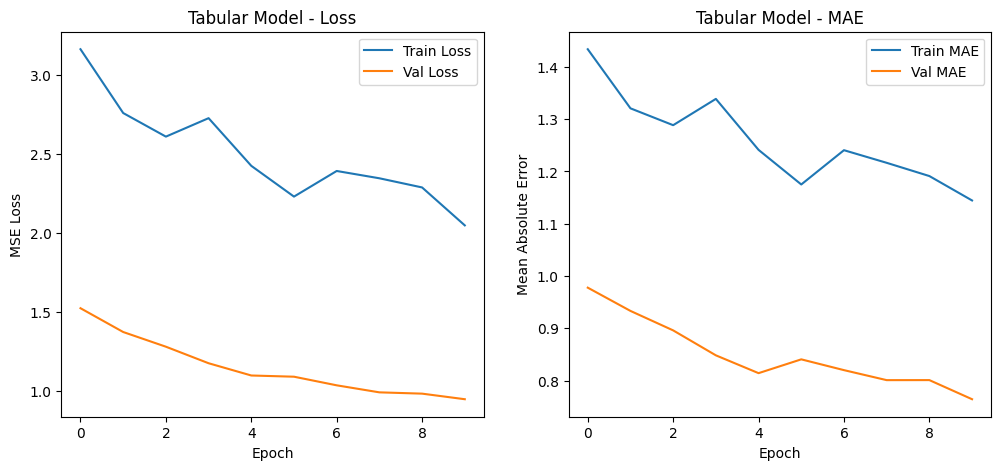

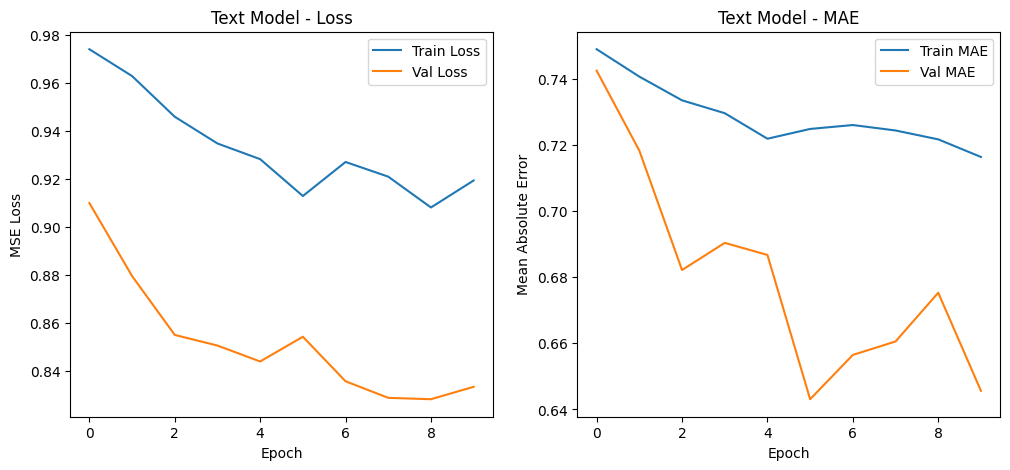

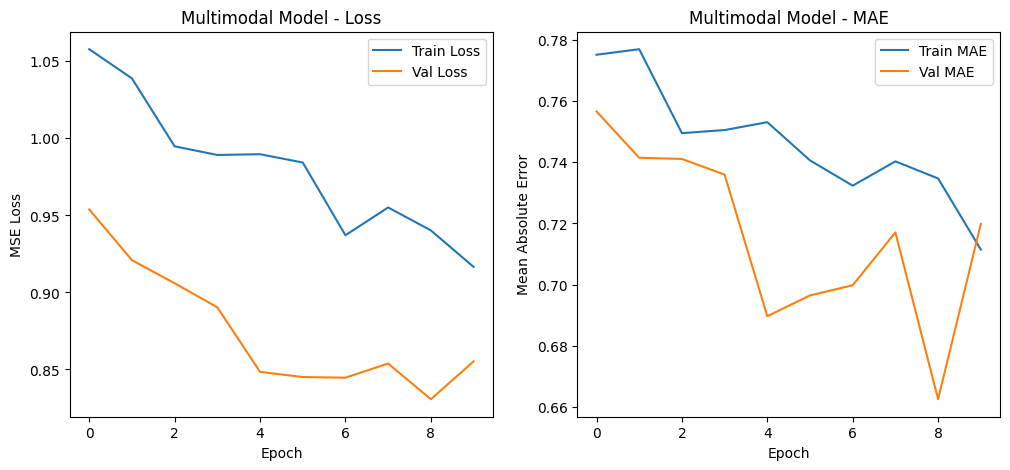

In [10]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    """Plot training vs validation loss & MAE for a given model."""
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()

    # MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title(f'{model_name} - MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()

    plt.show()


# Example usage (use your actual history objects from .fit())
plot_history(tabular_history, "Tabular Model")
plot_history(text_history, "Text Model")
plot_history(multimodal_history, "Multimodal Model")


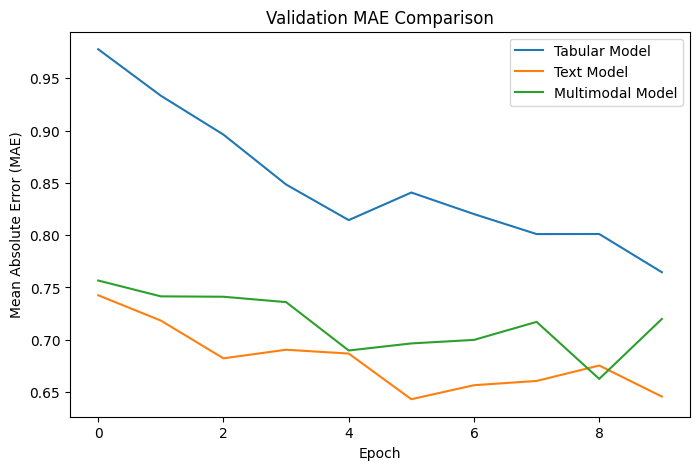

In [11]:
import matplotlib.pyplot as plt

# Compare validation MAE of all models in one plot
plt.figure(figsize=(8,5))

plt.plot(tabular_history.history['val_mae'], label='Tabular Model')
plt.plot(text_history.history['val_mae'], label='Text Model')
plt.plot(multimodal_history.history['val_mae'], label='Multimodal Model')

plt.title("Validation MAE Comparison")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.show()


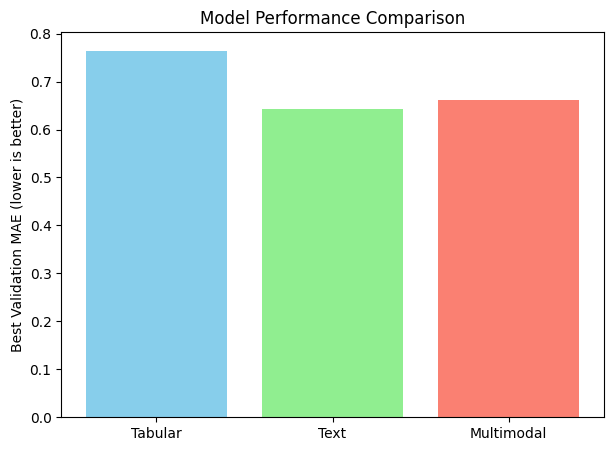

In [12]:
# Get best validation MAE from each model
best_tabular = min(tabular_history.history['val_mae'])
best_text = min(text_history.history['val_mae'])
best_multimodal = min(multimodal_history.history['val_mae'])

# Bar chart comparison
models = ['Tabular', 'Text', 'Multimodal']
best_mae = [best_tabular, best_text, best_multimodal]

plt.figure(figsize=(7,5))
plt.bar(models, best_mae, color=['skyblue','lightgreen','salmon'])
plt.ylabel("Best Validation MAE (lower is better)")
plt.title("Model Performance Comparison")
plt.show()
